# Imports

In [1]:
import pandas as pd
from ranx import Qrels, Run, compare
from tqdm import tqdm
from weaviate import Client


# Setup

In [2]:
MOVIE_CLASS = "MovieCos"
VIEW_CLASS = "ViewCos"

# connect to weaviate at weaviate:8080
client = Client("http://weaviate:8080")

client.batch.configure(batch_size=100)

# clear VIEW_CLASS by deleting and recreating the schema
schema = client.schema.get(VIEW_CLASS)
client.schema.delete_class(VIEW_CLASS)
client.schema.create_class(schema)

# call cluster node status
client.cluster.get_nodes_status()


[{'gitHash': 'f818156',
  'name': 'node1',
  'shards': [{'class': 'ViewCos', 'name': 'iLmb4a2tNAUb', 'objectCount': 0},
   {'class': 'Genre', 'name': 'bhuJm2ZYdJ7m', 'objectCount': 18},
   {'class': 'MovieCos', 'name': 'ff29Z3xcHcQr', 'objectCount': 3823}],
  'stats': {'objectCount': 3841, 'shardCount': 3},
  'status': 'HEALTHY',
  'version': '1.17.2'}]

In [3]:
# delete all classes except for the VIEW_CLASS, MOVIIE_CLASS and the Genre class
weaviate_classes = client.schema.get()["classes"]

for weaviate_class in weaviate_classes:
    class_name = weaviate_class["class"]
    if class_name not in [VIEW_CLASS, MOVIE_CLASS, "Genre"]:
        client.schema.delete_class(class_name)

client.cluster.get_nodes_status()


[{'gitHash': 'f818156',
  'name': 'node1',
  'shards': [{'class': 'ViewCos', 'name': 'iLmb4a2tNAUb', 'objectCount': 0},
   {'class': 'Genre', 'name': 'bhuJm2ZYdJ7m', 'objectCount': 18},
   {'class': 'MovieCos', 'name': 'ff29Z3xcHcQr', 'objectCount': 3823}],
  'stats': {'objectCount': 3841, 'shardCount': 3},
  'status': 'HEALTHY',
  'version': '1.17.2'}]

# Utility Functions

Functions to determine if a movie id exists in the database:

In [4]:
def get_movie_by_id(movie_id):
    results = client.query\
        .get(MOVIE_CLASS, ["movie_id", "title"])\
        .with_where({"path": ["movie_id"], "operator": "Equal", "valueString": movie_id})\
        .with_additional("id")\
        .do()
    results = results["data"]["Get"][MOVIE_CLASS]

    return results


def is_movie_id_exists(movie_id):
    results = get_movie_by_id(movie_id)

    return len(results) > 0


Functions to generate recommendations given a list of movie ids and a user id:

In [5]:
# define a function to get a movie uuid by movie id
def get_movie_uuid_by_id(movie_id):
    results = get_movie_by_id(movie_id)

    return results[0]["_additional"]["id"]

# TODO: figure out why this does not create a vector for the user


def create_user_views_buggy(user_id, movie_ids):
    movie_uuids = [get_movie_uuid_by_id(movie_id) for movie_id in movie_ids]

    with client.batch as batch:
        user_uuid = batch.add_data_object(
            {
                "user_id": user_id,
            },
            class_name=VIEW_CLASS
        )

        for movie_id in movie_ids:
            movie_uuid = get_movie_uuid_by_id(movie_id)

            batch.add_reference(
                from_object_uuid=user_uuid,
                from_object_class_name=VIEW_CLASS,
                from_property_name="movies",
                to_object_uuid=movie_uuid,
                to_object_class_name=MOVIE_CLASS
            )
    return user_uuid


def create_user_views(user_id, movie_ids, view_limit=None):
    # take the last view_limit movies if it is not None
    if view_limit is not None:
        movie_ids = movie_ids[-view_limit:]

    movie_uuids = [get_movie_uuid_by_id(movie_id) for movie_id in movie_ids]

    user_uuid = client.data_object.create(
        {"user_id": user_id},
        class_name=VIEW_CLASS
    )

    for movie_id in movie_ids:
        movie_uuid = get_movie_uuid_by_id(movie_id)
        client.data_object.reference.add(
            from_uuid=user_uuid,
            from_property_name="movies",
            to_uuid=movie_uuid,
            from_class_name=VIEW_CLASS,
            to_class_name=MOVIE_CLASS
        )

    return user_uuid


def get_user_embedding(user_uuid):
    user_embedding = client.query.get(VIEW_CLASS, ["user_id"]).with_additional("vector").with_where(
        {"path": ["id"], "operator": "Equal", "valueString": user_uuid}).do()

    return user_embedding["data"]["Get"][VIEW_CLASS][0]["_additional"]["vector"]


def build_and_clause(movie_ids):
    return {
        "operator": "And",
        "operands": [
            {
                "path": ["movie_id"],
                "operator": "NotEqual",
                "valueString": movie_id
            } for movie_id in movie_ids
        ]
    }


def get_recommendations(user_id, movie_ids, top_k=10, view_limit=None):
    user_uuid = create_user_views(user_id, movie_ids, view_limit=view_limit)

    user_embedding = get_user_embedding(user_uuid)

    near_vector = {
        "vector": user_embedding
    }

    excluded_movies = build_and_clause(movie_ids)

    results = client.query\
        .get(MOVIE_CLASS, ["movie_id"])\
        .with_where(excluded_movies)\
        .with_near_vector(near_vector)\
        .with_limit(top_k)\
        .do()

    results = results["data"]["Get"][MOVIE_CLASS]

    # extract movie ids
    return [result["movie_id"] for result in results]


Quick check if `create_user_views` creates a vector for that user's views:

In [6]:
user_id = "1"
viewing_history = ["3186", "1270", "1721", "1022", "2340"]

user_uuid_1 = create_user_views_buggy(user_id, viewing_history)
user_uuid_2 = create_user_views(user_id, viewing_history)


In [7]:
user_uuid_1_vector = client.query.get(VIEW_CLASS, ["user_id"]).with_additional("vector").with_where(
    {"path": ["id"], "operator": "Equal", "valueString": user_uuid_1}).do()

len(user_uuid_1_vector["data"]["Get"][VIEW_CLASS][0]["_additional"]["vector"])


0

In [8]:
user_uuid_2_vector = client.query.get(VIEW_CLASS, ["user_id"]).with_additional("vector").with_where(
    {"path": ["id"], "operator": "Equal", "valueString": user_uuid_2}).do()

user_uuid_2_vector = user_uuid_2_vector["data"]["Get"][VIEW_CLASS][0]["_additional"]["vector"]

len(user_uuid_2_vector)


768

In [9]:
client.data_object.delete(user_uuid_1, VIEW_CLASS)
client.data_object.delete(user_uuid_2, VIEW_CLASS)


# Dataset

In [10]:
# read the ratings.dat file in ml-1m
# timestamp column is number of seconds since 1970-01-01 00:00:00 UTC
ratings = pd.read_csv('../data/ml-1m/ratings.dat', sep='::',
                      names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')

# convert the timestamp to a datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# convert the movie_id and user_id to strings
ratings['movie_id'] = ratings['movie_id'].astype(str)
ratings['user_id'] = ratings['user_id'].astype(str)

ratings.head()


,user_id,movie_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


# Preprocessing

Drop rows where the movie id is not in the database:

In [11]:
# make a new dataframe with only the unique movie_ids
movies = ratings[['movie_id']].drop_duplicates()

# for each movie_id, check if it exists in weaviate
movies['exists'] = movies['movie_id'].apply(is_movie_id_exists)

# group by the exists column and count the number of movies
movies.groupby('exists').count()


,movie_id
exists,
False,45
True,3661


In [12]:
# from movies, select only the movies that do not exist in weaviate
movies_not_in_weaviate = movies[movies['exists'] == False]

# keep rows in ratings where the movie_id is not in movies_not_in_weaviate
ratings = ratings[~ratings['movie_id'].isin(
    movies_not_in_weaviate['movie_id'])]


Make a dataframe of user id and their viewing history which is the sequence of moviews they rated from earlier to lastest:

In [13]:
# sort x by the second elmement of the tuple
# and only return the first element of each tuple
def f(x):
    return list(map(lambda x: x[0], sorted(x, key=lambda x: x[1])))


# make a tuple from movie_id and timestamp
ratings['movie_id_timestamp'] = ratings.apply(
    lambda x: (x['movie_id'], x['timestamp']), axis=1)

# group by user_id and apply f on the movie_id_timestamp column
# name the column view_history
history = ratings.groupby('user_id')['movie_id_timestamp'].apply(
    f).reset_index(name='view_history')

history.head()


,user_id,view_history
0,1,"[3186, 1270, 1721, 1022, 2340, 1836, 3408, 280..."
1,10,"[597, 743, 858, 1948, 1210, 1282, 2312, 3751, ..."
2,100,"[1676, 260, 1198, 541, 1210, 3948, 3536, 2567,..."
3,1000,"[2990, 971, 260, 3068, 3153, 1210, 2973, 1610,..."
4,1001,"[1198, 1617, 2885, 3909, 1479, 3555, 3949, 389..."


<AxesSubplot: >

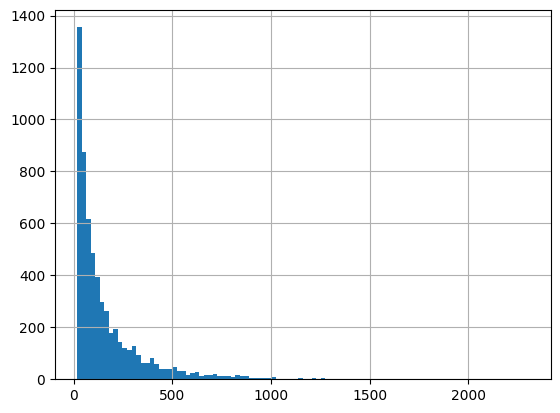

In [14]:
# make a histogram of the length of the view_history
history['view_history'].apply(len).hist(bins=100)


# Train Test Split

The training set is each users viewing history up to the last movie they rated. 

The test set is the last movie they rated.

In [15]:
# add column called train
# train is the everything in view_history except the last item
history['train'] = history['view_history'].apply(lambda x: x[:-1])
# due to compute limitations, we only consider the last 10 views
history['train'] = history['train'].apply(lambda x: x[-10:])

# add column called test
# test is the last item in view_history
history['test'] = history['view_history'].apply(lambda x: x[-1])

history.head()


,user_id,view_history,train,test
0,1,"[3186, 1270, 1721, 1022, 2340, 1836, 3408, 280...","[595, 2687, 745, 588, 1, 2355, 2294, 783, 1566...",48
1,10,"[597, 743, 858, 1948, 1210, 1282, 2312, 3751, ...","[3593, 275, 3034, 3447, 595, 923, 1704, 1283, ...",2252
2,100,"[1676, 260, 1198, 541, 1210, 3948, 3536, 2567,...","[1562, 1499, 593, 318, 527, 924, 608, 1213, 91...",1208
3,1000,"[2990, 971, 260, 3068, 3153, 1210, 2973, 1610,...","[2081, 2085, 2087, 1029, 318, 1299, 2804, 2132...",1104
4,1001,"[1198, 1617, 2885, 3909, 1479, 3555, 3949, 389...","[3824, 3854, 2609, 2769, 3902, 3743, 3317, 375...",2683


# Generate Recommendations

In [16]:
# select user_id, train and test into df
df = history[['user_id', 'train', 'test']]

# sample 5 rows from df
# df = df.sample(5)
# df


In [17]:
tqdm.pandas(desc="Progress")

# apply get_recommendations to each row in df
# to get 100 recommendations
# and assign it to the column recs
df['recs'] = df.progress_apply(lambda x: get_recommendations(
    x['user_id'], x['train'], top_k=100, view_limit=None), axis=1)

df.head()


Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6040/6040 [47:04<00:00,  2.14it/s]


,user_id,train,test,recs
0,1,"[595, 2687, 745, 588, 1, 2355, 2294, 783, 1566...",48,"[1197, 2632, 1275, 2628, 3932, 3139, 251, 1027..."
1,10,"[3593, 275, 3034, 3447, 595, 923, 1704, 1283, ...",2252,"[2579, 3016, 1791, 1197, 536, 1908, 2780, 558,..."
2,100,"[1562, 1499, 593, 318, 527, 924, 608, 1213, 91...",1208,"[2579, 2406, 1181, 558, 1027, 1394, 1275, 1209..."
3,1000,"[2081, 2085, 2087, 1029, 318, 1299, 2804, 2132...",1104,"[2579, 558, 812, 126, 3340, 3218, 2137, 1112, ..."
4,1001,"[3824, 3854, 2609, 2769, 3902, 3743, 3317, 375...",2683,"[2980, 347, 2146, 1961, 3466, 942, 3004, 2123,..."


# Evaluation

Define the query relevance judgements i.e. ground truth:

In [18]:
qrels = Qrels({user_id: {test: 1}
              for user_id, test in zip(df['user_id'], df['test'])})


Define the run i.e. the recommendations from the model:

In [19]:
# enumerate over the user id and recs column
# and create a dictionary with the user_id as key
# the value is a dictionary with the movie_id as key
# and the rank as value
run = Run({user_id: {rec: rank for rank, rec in enumerate(recs, 1)}
          for user_id, recs in zip(df['user_id'], df['recs'])}, name="simple vector search")


Calculate the metrics:

In [20]:
report = compare(qrels=qrels,
                 runs=[run],
                 metrics=['ndcg@10', 'recall@10', 'recall@100'])

report


#    Model                   NDCG@10    Recall@10    Recall@100
---  --------------------  ---------  -----------  ------------
a    simple vector search      0.002        0.005         0.057